In [2]:
pip install pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 4.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 2.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.3/502.3 kB 2.6 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [234]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [204]:
companies_data = pd.read_csv('affiliates.csv', sep=';')
orders_data = pd.read_csv('affiliate_orders.csv')

# Подготовка таблицы для анализа

#### Я отбираю из таблицы заказов актуальные (за последние полгода), затем группирую по парнерам и сопоставляю каждому парнеру количество экскурсий (успешных, отменненых, еще не состоявщихся). После этого добавляю столбец с количеством переходов на сайт Спутника. Теперь у меня есть удобная для анализа таблица.

In [215]:
start_date = datetime.strptime('2023-01-01 00:00:00.000000', '%Y-%m-%d %H:%M:%S.%f')
end_date = datetime.strptime('2023-06-29 23:59:59.999999', '%Y-%m-%d %H:%M:%S.%f')
orders_data['created_at'] = pd.to_datetime(orders_data['created_at'])
filtered_orders_data = orders_data[(orders_data['created_at'] >= start_date) & (orders_data['created_at'] <= end_date)]
pivot_df = filtered_orders_data.pivot_table(index='affiliate_id', columns='state', aggfunc='size', fill_value=0)
pivot_df.columns = ['canceled', 'held', 'pending']
result_df = pivot_df.reset_index()
merged_df = result_df.merge(companies_data, how='left', left_on='affiliate_id', right_on='id')
merged_df.drop(columns=['id', 'created_at'], inplace=True)
merged_df = merged_df.sort_values(by=['canceled', 'held', 'pending'], ascending=[False, False, False])
merged_df

,affiliate_id,canceled,held,pending,traffic_amount
6,151,23424,37646,9945,1434704
82,3618,2886,5458,1,0
79,3533,2181,1673,237,25553
0,1,1611,2157,376,105208
78,3421,1332,2056,354,108881
...,...,...,...,...,...
139,4883,0,1,0,16
151,5098,0,1,0,46
144,4928,0,0,2,20
4,131,0,0,1,1


# Задание 1

## Общий анализ данных

#### Чтобы узнать какие парнеры работают наименее и наболее эффективно мне требуется отранжировать списки по разным метрикам (количество переходов, количество проведенных экскурсий, отношение успешно проведенных экскурсий к отмененным экскурсиям, отношение количества проведенных экскурсий к количеству переходов).

In [240]:
traffic_amount = merged_df.loc[merged_df['traffic_amount']>2000]
traffic_amount = traffic_amount.sort_values('traffic_amount', ascending=False)
total_traffic_good_company = traffic_amount['traffic_amount'].sum()
traffic_amount

,affiliate_id,canceled,held,pending,traffic_amount
6,151,23424,37646,9945,1434704
86,3792,409,970,653,653855
67,2704,3,1,0,360855
74,3340,304,575,296,180385
78,3421,1332,2056,354,108881
0,1,1611,2157,376,105208
15,555,1134,1495,138,92118
57,2132,771,1634,599,87665
33,1208,6,7,2,53630
24,1032,370,938,328,42860


#### Получилось отобрать компании, которые приносят хороший трафик на сайт, однако не у всех компаний этот трафик полезный, например, для компаний с id 1208, 2704, 2355, 4504 практически не происходит оформлений экскурсий.

In [226]:
state_amount = merged_df[merged_df[['canceled', 'held', 'pending']].sum(axis=1) >= 100]
state_amount = state_amount.sort_values(by=['canceled', 'held', 'pending'], ascending=[False, False, False])
state_amount['ratio'] = state_amount['held']/state_amount['canceled']
state_amount


,affiliate_id,canceled,held,pending,traffic_amount,ratio
6,151,23424,37646,9945,1434704,1.607155
82,3618,2886,5458,1,0,1.891199
79,3533,2181,1673,237,25553,0.767079
0,1,1611,2157,376,105208,1.338920
78,3421,1332,2056,354,108881,1.543544
15,555,1134,1495,138,92118,1.318342
57,2132,771,1634,599,87665,2.119326
46,1683,583,464,0,0,0.795883
86,3792,409,970,653,653855,2.371638
24,1032,370,938,328,42860,2.535135


#### Получилось отобрать компании, которые проводят наибольшее количество экскурсий, однако не все компании ведут на Спутник трафик. Например, компании с id 3618, 1683 вообще не приводят пользователей. Также у компаний 3533, 1683, 4333, 566, 2431 количество отмен экскурсий больше, чем количество успешно проведенных экскурсий. Хоть и компании 4260, 3358 проводят немного экскурсий, но они являются очень надежными из-за малого количества отмененных экскурсий.

In [241]:
other_bad_company = merged_df.loc[merged_df['traffic_amount']<2000]
other_bad_company = other_bad_company[other_bad_company[['canceled', 'held', 'pending']].sum(axis=1) <= 100]
total_traffic_bad_company = other_bad_company['traffic_amount'].sum()
other_bad_company

,affiliate_id,canceled,held,pending,traffic_amount
20,934,10,11,1,1955
90,3887,27,41,2,1850
65,2650,7,0,1,1695
108,4433,9,3,10,1662
91,3965,0,1,0,1584
...,...,...,...,...,...
87,3801,1,2,1,2
141,4907,2,1,0,1
130,4757,1,0,0,1
4,131,0,0,1,1


#### Получена таблица с компаниями, которые приносят мало трафика

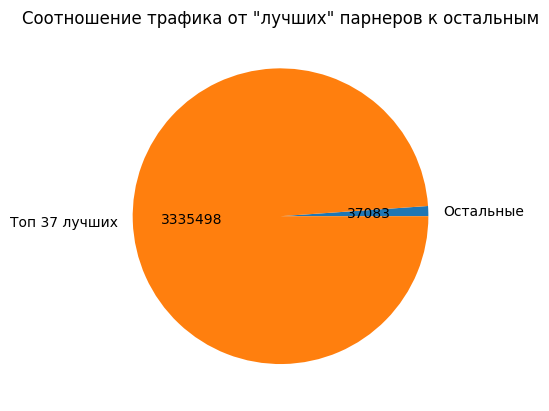

In [295]:
total = total_traffic_bad_company + total_traffic_good_company
sizes = [total_traffic_bad_company, total_traffic_good_company]
labels = ['Остальные', 'Топ 37 лучших']
plt.pie(sizes, labels=labels, autopct=lambda p: '{:.0f}'.format(p * total / 100))
plt.title('Соотношение трафика от "лучших" парнеров к остальным')
plt.show()

## Вывод о наиболее и наименее эффективных компаниях

#### Вывод о наиболее и наименее эффективных компаниях может получиться не объективным, так как нельзя проанализировать такие параметры, как средняя цена экскурсии, среднее количество людей на экскурсии, затраты на сотрудничество с компанией. Однако добавим столбец, в котором будем хранить отношение успешно проведенных экскурсий и ожидающих проведения к трафику. Уберем те, которые провели меньше 10 экскурсий, и те, которые привели меньше 100 человек.

In [251]:
state_amount2 = merged_df[merged_df[['canceled', 'held', 'pending']].sum(axis=1) >= 10]
state_amount2 = state_amount2.loc[state_amount2['traffic_amount']>1000]
state_amount2['ratio2'] = merged_df[['held', 'pending']].sum(axis=1)/merged_df['traffic_amount']
state_amount2 = state_amount2.sort_values('ratio2', ascending = False)
state_amount2

,affiliate_id,canceled,held,pending,traffic_amount,ratio2
71,2781,368,695,79,7950,0.097358
79,3533,2181,1673,237,25553,0.074747
38,1492,26,63,8,1311,0.054157
105,4333,353,298,12,6931,0.044727
103,4260,21,237,39,6342,0.043519
6,151,23424,37646,9945,1434704,0.033171
110,4493,280,536,49,17650,0.033144
76,3358,19,96,22,3933,0.030003
24,1032,370,938,328,42860,0.029538
32,1186,146,197,62,8820,0.029365


#### Получили отранжированный список компаний по их эффективности. Если учесть, что у некоторых компаний слишком много отмененных экскурсий, по сравнению с успешно завершенными, то компании с id: 3533, 4333, 138 - не являются эффективными.

# Задание 2

#### В этом задании очень много различных путей, которым можно следовать. Например, 1) можно поработать с компаниями, у которых много отказов, разобраться почему; 2) поработать с компаниями, отношение переходов с сайтов которых к количеству экскурсий хорошее, чтобы переходов стало еще больше; 3) поработать с компаниями, с которых большое количество переходов, но мало проведенных экскурсий; 4) поработать с компаниями, у которых много экскурсий, но нет трафика.
#### 1) 3533, 1683, 4333, 1781, 3651, 566, 2431, 138, 1712
#### 2) 2781, 3533, 1492, 4260, 3358, 543, 4874, 2132
#### 3) 3792, 2704, 1208
#### 4) 3618, 1683
#### Топ 15: 3533, 1683, 4333, 1781, 3651, 2781, 4260, 1492, 4260, 3792, 2704, 1208, 3618, 566.

# Задание 3

#### Для начала я хочу узнать, как меняется количество экскурсий в течение года, для этого нужно сгрупировать экскурсии по месяцам и посчитать их количество.

In [253]:
df_per_month = orders_data
df_per_month['month'] = orders_data['created_at'].dt.to_period('M')
monthly_order_counts = orders_data.groupby('month').size().reset_index(name='order_count')
monthly_order_counts

,month,order_count
0,2022-05,15138
1,2022-06,24188
2,2022-07,30953
3,2022-08,27898
4,2022-09,15146
5,2022-10,13254
6,2022-11,10858
7,2022-12,9293
8,2023-01,11812
9,2023-02,10847


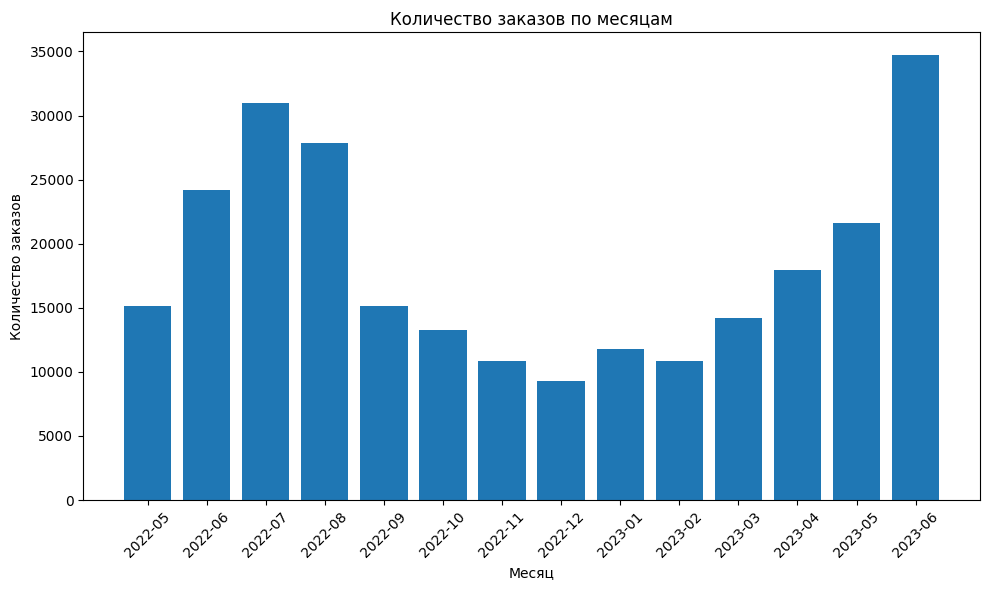

In [255]:
monthly_order_counts['month'] = monthly_order_counts['month'].dt.strftime('%Y-%m')
plt.figure(figsize=(10, 6))
plt.bar(monthly_order_counts['month'], monthly_order_counts['order_count'])
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.title('Количество заказов по месяцам')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Можно заметить, что пиковые значения приходятся на летние месяцы, что логично. Теперь, чтобы спрогнозировать количество экскурсий на август и сентябрь, я найду количество экскурсий за август и сентябрь прошлого года, затем найду коэффициент (во сколько раз увеличилось количество экскурсий за год).

In [280]:
may_2022 = monthly_order_counts[
    (monthly_order_counts['month'].str.startswith('2022-05'))
]
order_count_may_2022 = may_2022['order_count'].sum()
june_2022 = monthly_order_counts[
    (monthly_order_counts['month'].str.startswith('2022-06'))
]
order_count_june_2022 = june_2022['order_count'].sum()
august_2022 = monthly_order_counts[
    (monthly_order_counts['month'].str.startswith('2022-08'))
]
order_count_august_2022 = august_2022['order_count'].sum()
september_2022 = monthly_order_counts[
    (monthly_order_counts['month'].str.startswith('2022-09'))
]
order_count_september_2022 = september_2022['order_count'].sum()
may_2023 = monthly_order_counts[
    (monthly_order_counts['month'].str.startswith('2023-05'))
]
order_count_may_2023 = may_2023['order_count'].sum()
june_2023 = monthly_order_counts[
    (monthly_order_counts['month'].str.startswith('2023-06'))
]
order_count_june_2023 = june_2023['order_count'].sum()
print("Отношение 2023 к 2022 за май: ", order_count_may_2023/order_count_may_2022)
print("Отношение 2023 к 2022 за июнь: ", order_count_june_2023/order_count_june_2022)
print("Количество проведенных экскурсий за август и сентябрь 2022 года: ", order_count_august_2022 + order_count_september_2022)
print("Прогнозируемое количество экскурсий в августе и сентябре 2023 года: ", round((order_count_august_2022 + order_count_september_2022)*order_count_may_2023/order_count_may_2022, 0))

Отношение 2023 к 2022 за май:  1.4288545382481173
Отношение 2023 к 2022 за июнь:  1.4369522077063006
Количество проведенных экскурсий за август и сентябрь 2022 года:  43044
Прогнозируемое количество экскурсий в августе и сентябре 2023 года:  61504.0


#### Было взято отношение за май, так как июнь является одним из пиковых месяцем и целесообразнее брать месяц, который ближе к обычному. Полученный прогноз : 61504 экскурсии.

#### Теперь подумаем над тем, как мог бы измениться прогноз, если бы выбранные компании стали работать лучше. 1) Для компаний, в которых количество отмен большое, сложно прогнозировать изменения, скорее улучшения в этом случае напрямую повлияют на прибыль Спутника, так как отмененные экскурсии это потерянные деньги. На репутацию, к слову, это тоже повлияет. 2) Для компаний, у которых хорошее отношение переходов к заказам, также сложно спрогнозировать изменение, так как это зависит от количества средств, которые будут в это вложены и ресурс самих партнеров, могут ли они сами увеличить оборот экскурсий и трафик. 3) Для компаний, у которых большой трафик, но мало проведенных экскурсий можно пойти по двум путям: продолжать увеличивать трафик, оставляя соотношение прежним (опять же зависит от ресурсов); либо поработать над заинтересованностью, увеличив соотношение трафика к эскурсиям (но это уже будет другая реклама). 4) Для компаний, у которых много экскурсий, но нет трафика, разобравшись, почему так происходит, можно увеличить сам трафик на сайт Спутника.

In [293]:
avg = state_amount2['ratio2'].median()

company_ids = [3792, 2704, 1208]
sum_columns = ['canceled', 'held', 'pending']
total_sum = 0

for company_id in company_ids:
    filtered_df = merged_df[merged_df['affiliate_id'] == company_id]
    total_sum += filtered_df[sum_columns].sum().sum()

total_traffic_amount = merged_df.loc[merged_df['affiliate_id'].isin(affiliate_ids), 'traffic_amount'].sum()
print("Сейчас: ", total_sum)
print("Может стать: ", round(total_traffic_amount * avg,0))

Сейчас:  2051
Может стать:  22423.0


#### Это пример, сколько могли бы принести компании из группы 3) за год, если бы их соотношение трафика к экскурсиям равнялось медиане.